# Phase 3 Data Science Training Notebook

In [7]:
import pandas as pd
import numpy as np

## Exploratory Data Analysis

In [8]:
# Assume tar.gz file to be extracted at project directory.
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [9]:
train_batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
train_batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
train_batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
train_batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
train_batch_5 = unpickle('cifar-10-batches-py/data_batch_5')
test_batch = unpickle('cifar-10-batches-py/test_batch')

In [10]:
def reshape_image(data):
    data = np.reshape(data, (3,32,32))
    data = np.moveaxis(data, 0, -1)

    return data

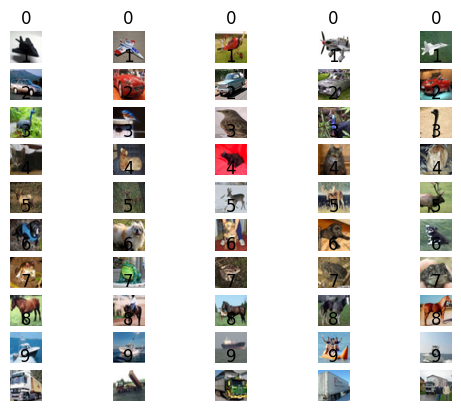

In [11]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=5)

for i in range(10):
    count = 0
    j = 0
    while count < 5:
        if train_batch_1[b'labels'][j] == i:
            axs[i][count].imshow(reshape_image(train_batch_1[b'data'][j]))
            axs[i][count].axis('off')
            axs[i][count].set_title(i)
            count += 1
        j += 1


# Data Processing

In [12]:
def filter_classes(batch, label):
    x = []
    y = []

    true_count = 0
    false_count = 0

    labels = np.array([int(i == label) for i in batch[b'labels']])

    _, counts = np.unique(labels, return_counts=True)
    n = min(counts)

    for i in range(len(batch[b'data'])):
        if batch[b'labels'][i] == label:
            if true_count < n:
                x.append(reshape_image(batch[b'data'][i]))
                y.append(1)
                true_count += 1
        else:
            if false_count < n:
                x.append(reshape_image(batch[b'data'][i]))
                y.append(0)
                false_count += 1

    return np.array(x), np.array(y)

In [13]:
# train_x = np.random.randint(0,255,size=(10000,3,32,32))
# train_y = np.random.randint(0,255,size=(10000))

# test_x = np.random.randint(0,255,size=(1000,3,32,32))
# test_y = np.random.randint(0,255,size=(1000))

train_x1, train_y1 = filter_classes(train_batch_1, 0)
train_x2, train_y2 = filter_classes(train_batch_2, 0)
train_x3, train_y3 = filter_classes(train_batch_3, 0)
train_x4, train_y4 = filter_classes(train_batch_4, 0)
train_x5, train_y5 = filter_classes(train_batch_5, 0)

train_x = np.concatenate((train_x1, train_x2, train_x3, train_x4, train_x5))
train_y = np.concatenate((train_y1, train_y2, train_y3, train_y4, train_y5))
test_x, test_y = filter_classes(test_batch, 0)


# train_x = train_batch_1[b'data']
# train_y = np.array([int(label == 0) for label in train_batch_1[b'labels']])

# test_x = test_batch[b'data'][:1000]
# test_y = np.array([int(label == 0) for label in test_batch[b'labels'][:1000]])

In [14]:
np.unique(train_y, return_counts=True)

(array([0, 1]), array([5000, 5000], dtype=int64))

In [15]:
np.unique(test_y, return_counts=True)

(array([0, 1]), array([1000, 1000], dtype=int64))

# Data Modelling

In [16]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks
from datetime import datetime

In [27]:
def generateModel():
    """
    Make a Keras Sequential Model.
    Feel free to change the layout of the layers.

    Read more about keras here: https://keras.io/api/
    Tensorflow setup adapted here: https://www.tensorflow.org/tutorials/quickstart/beginner
    """
    data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal",
        input_shape=(32,32,3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
    )

    model = Sequential(name="Image_Recognition_Model")
    model.add(Input(shape=(32,32,3,))) # Input layer.

    model.add(data_augmentation)
    model.add(layers.Rescaling(scale=1./255, name="Normaliser")) # Example pre-processing layer.
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(72, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(104, activation='relu'))
    model.add(layers.Dense(2))

    model.compile(
        optimizer='adam', #optimizers.SGD(learning_rate=0.1),
        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

In [20]:
model = generateModel()

date = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")

log_dir = "output\\logs\\"

# Callbacks for QoL.
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=500,
    batch_size=1000, # Set this to a lower number if your computer spec is bad.
    callbacks=[tensorboard_callback, earlystop_callback],
    # verbose=0 # Uncomment this line to reduce the printing on console.
)

Epoch 1/500
10/10 [==============================] - 10s 882ms/step - loss: 0.6559 - accuracy: 0.5939 - val_loss: 0.5848 - val_accuracy: 0.7055
Epoch 2/500
10/10 [==============================] - 9s 902ms/step - loss: 0.5727 - accuracy: 0.7179 - val_loss: 0.5250 - val_accuracy: 0.7535
Epoch 3/500
10/10 [==============================] - 9s 868ms/step - loss: 0.5467 - accuracy: 0.7361 - val_loss: 0.5121 - val_accuracy: 0.7650
Epoch 4/500
10/10 [==============================] - 9s 884ms/step - loss: 0.5269 - accuracy: 0.7523 - val_loss: 0.5060 - val_accuracy: 0.7565
Epoch 5/500
10/10 [==============================] - 9s 909ms/step - loss: 0.5061 - accuracy: 0.7631 - val_loss: 0.4673 - val_accuracy: 0.7885
Epoch 6/500
10/10 [==============================] - 9s 952ms/step - loss: 0.4834 - accuracy: 0.7761 - val_loss: 0.4421 - val_accuracy: 0.7985
Epoch 7/500
10/10 [==============================] - 9s 917ms/step - loss: 0.4649 - accuracy: 0.7850 - val_loss: 0.4440 - val_accuracy: 0.803

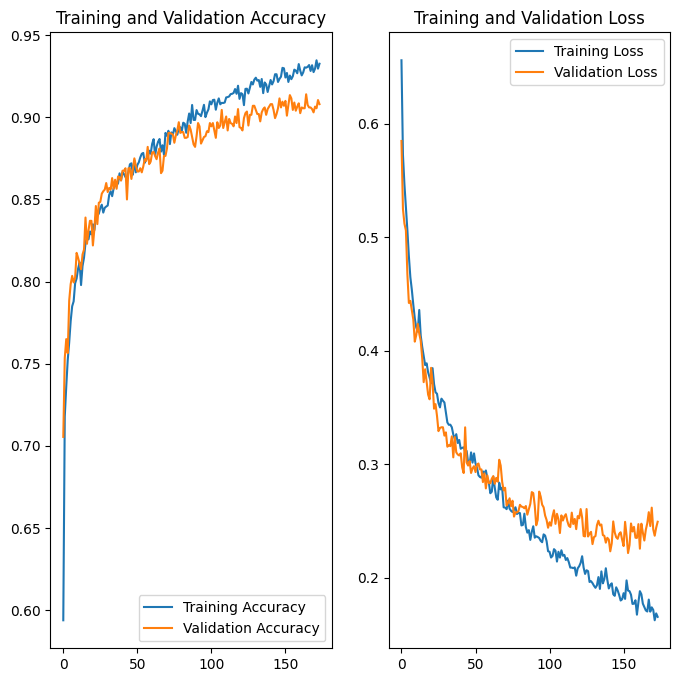

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(174)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
model.evaluate(test_x, test_y)

63/63 [==============================] - 1s 10ms/step - loss: 0.2218 - accuracy: 0.9135


[0.22181959450244904, 0.9135000109672546]

In [24]:
model.save('output\my_model5')

INFO:tensorflow:Assets written to: output\my_model5\assets


INFO:tensorflow:Assets written to: output\my_model5\assets
